## Estadística Aplicada

Nombre: Barbara Govea Serna

Matrícula: 1902869

Grupo: 042

Fecha: 24-Oct-2023

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf,plot_predict
from statsmodels.tsa.arima.model import ARIMA 

import pmdarima as pm 

In [3]:
## Datos
df_amazon=pd.read_excel('amazon.xlsx')
df_amazon

,fecha,amazon
0,2015-01-02,24.573591
1,2015-01-05,23.830631
2,2015-01-06,24.070295
3,2015-01-07,24.453760
4,2015-01-08,24.301968
...,...,...
1250,2019-12-23,52.589653
1251,2019-12-24,52.599163
1252,2019-12-26,52.561153
1253,2019-12-27,52.865196


In [4]:
df_amazon.dtypes

fecha     datetime64[ns]
amazon           float64
dtype: object

In [5]:
ultima_obs = df_amazon.loc[1254]
df_amazon = df_amazon.loc[:1253] # Queremos pronosticar nuestra ultima obs, para ver que tan buen modelo es

In [6]:
df_amazon

,fecha,amazon
0,2015-01-02,24.573591
1,2015-01-05,23.830631
2,2015-01-06,24.070295
3,2015-01-07,24.453760
4,2015-01-08,24.301968
...,...,...
1249,2019-12-20,54.128864
1250,2019-12-23,52.589653
1251,2019-12-24,52.599163
1252,2019-12-26,52.561153


In [7]:
ultima_obs

fecha     2019-12-30 00:00:00
amazon              51.478008
Name: 1254, dtype: object

In [8]:
df_amazon = df_amazon.set_index('fecha')

In [9]:
# Info de los días habiles 
# Asignar frecuencia de días habiles 
df_amazon = df_amazon.asfreq('B')

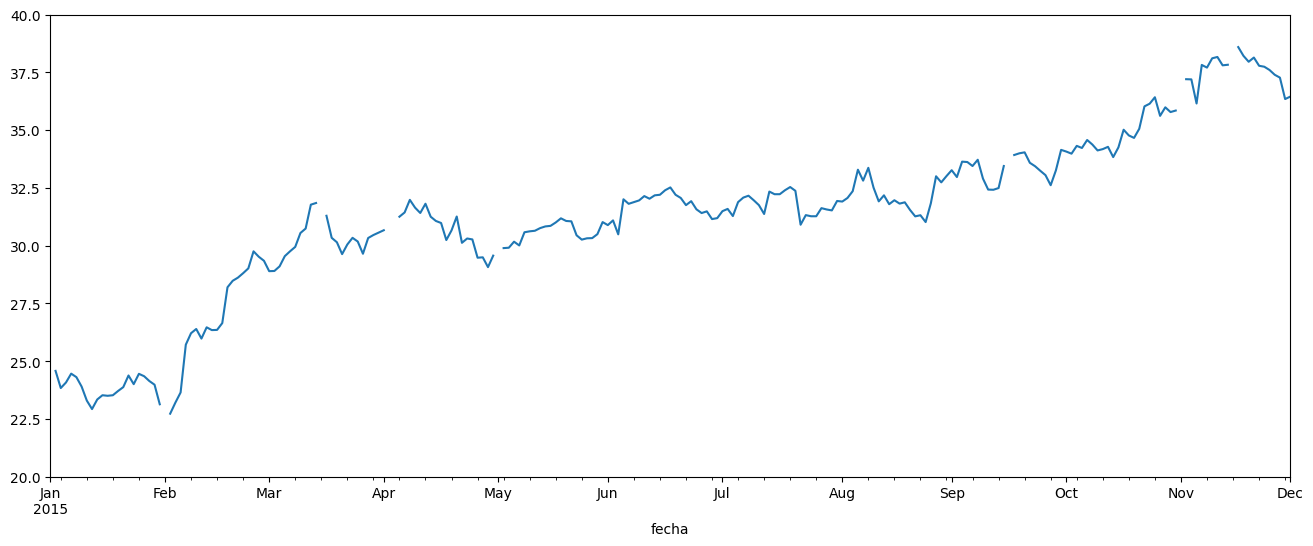

In [10]:
df_amazon['amazon'].plot(figsize=(16,6))
plt.xlim('2015-01-01','2015-12-01')
plt.ylim(20,40);

Notese que hay missing values, esta cortada, vamos a corroborarlo

In [11]:
df_amazon['amazon'].isnull().sum()

47

Imputaremos con el unico valor conocido

In [12]:
df_amazon['amazon'] = df_amazon['amazon'].fillna(method='pad')

Text(0.5, 0, 'días hábiles')

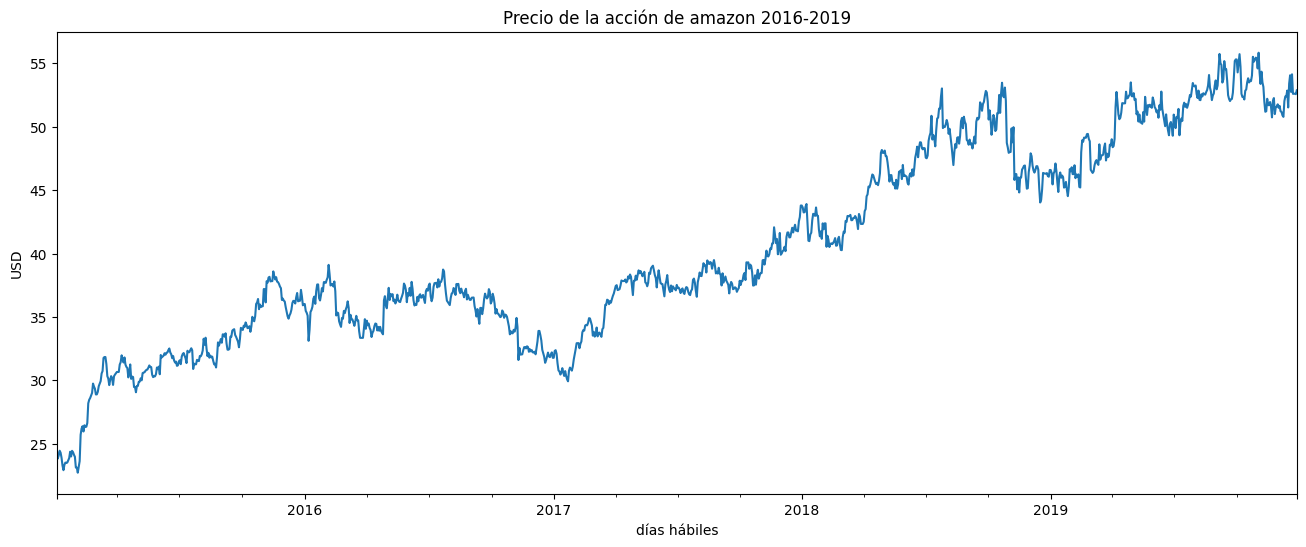

In [13]:
# Verificamos que la serie ya no tenga cortes
df_amazon['amazon'].plot(figsize=(16,6))
plt.title('Precio de la acción de amazon 2016-2019')
plt.ylabel('USD')
plt.xlabel('días hábiles')
# No parece q la manipulamos

In [14]:
# Prueba de dickey fuller
prueba_adf = adfuller(df_amazon['amazon'])
pvalue = prueba_adf[1]
pvalue.round(2)

0.52

Como el pvalue > .05, entonces no rechazamos H0, el precio de la accion de amazon es una serie no estacionaria

In [15]:
# Aplicar primeras diferencias 
df_amazon['amazon_diff'] = df_amazon['amazon'].diff()

In [16]:
df_amazon.head()

,amazon,amazon_diff
fecha,,
2015-01-02,24.573591,NaN
2015-01-05,23.830631,-0.742960
2015-01-06,24.070295,0.239664
2015-01-07,24.453760,0.383465
2015-01-08,24.301968,-0.151793


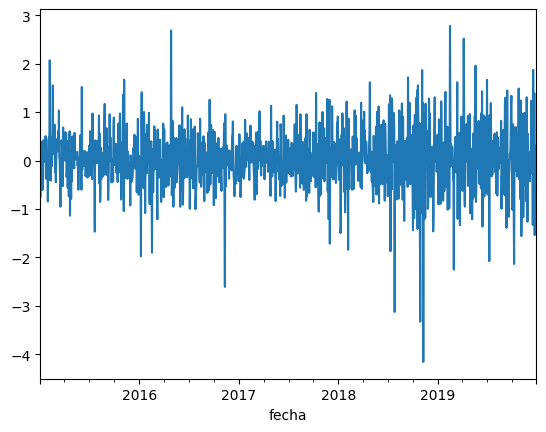

In [17]:
df_amazon['amazon_diff'].plot();

In [18]:
prueba_adf1 = adfuller(df_amazon['amazon_diff'].dropna())
pvalue1 = prueba_adf1[1]
pvalue1.round(2)

0.0

Se rechaza H0, signific que las primeras diferencias son estacionarias
- Amazon integrada I (1) = ARIMA(p,1,q)
- 1eras diferencias de amazon I (0) = ARIMA (p,0,q)

Estacional: Subidas y caidas siempre en la misma fecha 

Estacionaria: Media, varianza y cov a constante 

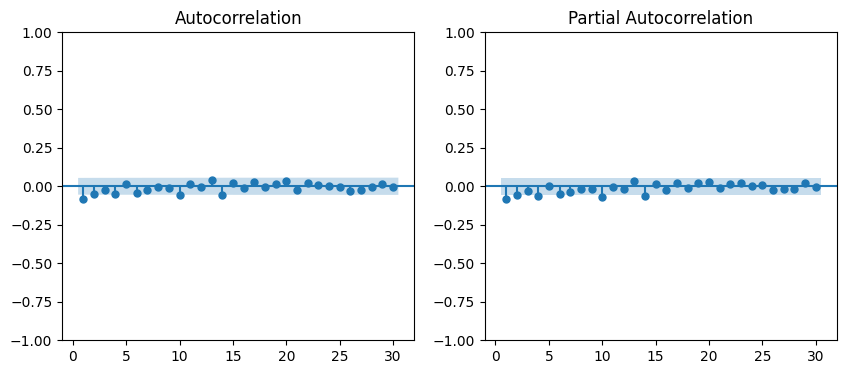

In [19]:
# Grafica de correlación
ig, ax = plt.subplots(1,2, figsize=(10,4))
# Graf1
plot_acf(df_amazon['amazon_diff'].dropna(),zero=False,lags=30,ax=ax[0])
# Graf2
plot_pacf(df_amazon['amazon_diff'].dropna(),zero=False,lags=30,ax=ax[1])
plt.show()

In [20]:
# Encontrar el orden del ARIMA AMAZON
pm.auto_arima(df_amazon['amazon'],
              start_p= 1,
              start_q=1,
              max_p=7,
              max_q = 7,
              ic= 'aic',
              seasonal= False
)

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

In [21]:
# Encontrar el orden del ARIMA AMAZON
pm.auto_arima(df_amazon['amazon_diff'].dropna(),
              start_p= 1,
              start_q=1,
              max_p=7,
              max_q = 7,
              ic= 'aic',
              seasonal= False
)

ARIMA(order=(1, 0, 1), scoring_args={}, suppress_warnings=True)

In [22]:
model = ARIMA(df_amazon['amazon'], order=(1,1,1))
results=model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                 amazon   No. Observations:                 1301
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1183.529
Date:                Tue, 24 Oct 2023   AIC                           2373.058
Time:                        15:36:26   BIC                           2388.569
Sample:                    01-02-2015   HQIC                          2378.878
                         - 12-27-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7500      0.071     10.517      0.000       0.610       0.890
ma.L1         -0.8375      0.059    -14.285      0.000      -0.952      -0.723
sigma2         0.3616      0.008     43.599      0.0

In [23]:
results.predict('2019-12-28','2020-01-05')
# El dia 28 y 29 no lo prostico porque es sabado y domingo 

2019-12-30    52.847340
2019-12-31    52.833947
2020-01-01    52.823902
2020-01-02    52.816367
2020-01-03    52.810716
2020-01-06    52.806477
Freq: B, Name: predicted_mean, dtype: float64

In [27]:
# Obtener el intervalo de confianza de los pronosticos 
forecast = results.get_forecast(steps=6)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()


In [28]:
inicio= '2019-12-30'
final= '2020-01-06'

In [30]:
pronostico_valor = forecast_mean[inicio:final]
pronostico_intervalos = forecast_ci.loc[inicio:final]


In [31]:
pronostico_valor

2019-12-30    52.847340
2019-12-31    52.833947
2020-01-01    52.823902
2020-01-02    52.816367
2020-01-03    52.810716
2020-01-06    52.806477
Freq: B, Name: predicted_mean, dtype: float64

In [33]:
pronostico_intervalos

,lower amazon,upper amazon
2019-12-30,51.668690,54.025990
2019-12-31,51.238282,54.429612
2020-01-01,50.941672,54.706131
2020-01-02,50.712311,54.920423
2020-01-03,50.523483,55.097949
2020-01-06,50.361404,55.251551


In [43]:
df_pronostico = pd.DataFrame({'pronostico': pronostico_valor,
                              'limite inferior': pronostico_intervalos.iloc[:,0],
                              'limite superior': pronostico_intervalos.iloc[:,1]
                              })
df_pronostico

,pronostico,limite inferior,limite superior
2019-12-30,52.847340,51.668690,54.025990
2019-12-31,52.833947,51.238282,54.429612
2020-01-01,52.823902,50.941672,54.706131
2020-01-02,52.816367,50.712311,54.920423
2020-01-03,52.810716,50.523483,55.097949
2020-01-06,52.806477,50.361404,55.251551


In [46]:
print(f'El pronostico de la accion de amazon para el día 30 de diciembre de 2019 es {df_pronostico.iloc[0,0].round(2)} con un valor minimo de {df_pronostico.iloc[0,1].round(2)} y un valor máximo de {df_pronostico.iloc[0,2].round(2)}')

El pronostico de la accion de amazon para el día 30 de diciembre de 2019 es 52.85 con un valor minimo de 51.67 y un valor máximo de 54.03


In [47]:
ultima_obs

fecha     2019-12-30 00:00:00
amazon              51.478008
Name: 1254, dtype: object